In [31]:
import csv
import re
import nltk
import datetime
#nltk.download('stopwords')
import time
import pandas as pd
import os, sys
import matplotlib.pylab as plt
stopwords = nltk.corpus.stopwords.words("english")
from afinn import Afinn
from datetime import datetime, timedelta
CALENDAR = ["", 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
DAYS = 365
afinn = Afinn()

#Creates dicts that hold the restaurants and their airdates
DDD_shows = {}
MvF_shows = {}
Best_shows = {}

In [44]:
Dates_and = {}
Dates_and['1'] = 'January'
Dates_and['01'] = 'January'
Dates_and['2'] = 'February'
Dates_and['3'] = 'March'
Dates_and['4'] = 'April'
Dates_and['5'] = 'May'
Dates_and['6'] = 'June'
Dates_and['7'] = 'July'
Dates_and['8'] = 'August'
Dates_and['9'] = 'September'
Dates_and['10'] = 'October'
Dates_and['11'] = 'November'
Dates_and['12'] = 'December'

In [32]:
path = '../Desktop/ManVSFood'
path2 = '../Desktop/DinersDriveIns'
path3 = '../Desktop/BestThing'

#allows us to iterate through all of the files within our folder of csv's
def matchlist_iter(folder_path):
    files = [file_path for file_path in os.listdir(folder_path) if file_path.endswith('.csv')]
    return files
snails = matchlist_iter(path)
turtles = matchlist_iter(path2)
tortoise = matchlist_iter(path3)



In [33]:
#fills in the dictionaries made earlier
def shows_and_dates(filename):
    with open(filename) as restFile:
        dict = {}
        for rows in restFile:
            tokens = rows.split(',')
            cats = tokens[2].split('\n')
            dict[tokens[0]]= cats[0]
        dict.pop('rest_name')
        return dict
        

In [34]:
#Converts the names of the csv files into the style of the keys
def wordToDict(name):
    tokens = name.split('_reviews')
    for i in range(len(tokens[0])):
        if tokens[0][i-1:i+2].count(" _ "):
            tokens[0] = tokens[0][:i]+'&'+tokens[0][i+1:]
    for i in range(len(tokens[0])):
        if tokens[0][i].count('_'):
            tokens[0] = tokens[0][:i]+"'"+tokens[0][i+1:]
    return tokens[0]

In [35]:
DDD_shows = shows_and_dates('DinersDriveInsAndDives - Sheet1.csv')
MvF_shows = shows_and_dates('ManVsFood - Sheet1.csv')
Best_shows = shows_and_dates('BestThingIEverAte - Sheet1.csv')

In [36]:
def get_clean_words(markup):
    def _isnum(w):
        try:
            int(w)
            return True
        except ValueError:
            return False
        
    # Load her markup


    # Remove table and external links
    markup_text = re.sub(r'\{\{[\s\S]*?\}\}', '', markup)

    # Remove category links
    markup_text = re.sub(r'\[\[Category.+\]\]', '', markup_text)

    # Set words to lowercase and remove them if they are stop words
    words = [w.lower() for w in re.findall('\w+', markup_text) if w.lower() not in stopwords]

    # Remove numbers
    words = [w for w in words if not _isnum(w)]

    return words

In [37]:
#extract the dates from each item passed in
def filestuff(filename, row):
    with open(filename) as file:
        for line in file:
            if line == row:
                index = row.find('Reviewed', -30)
                data = line[index+9:-2].strip("'")

                if 'yesterday' in data:
                    date = datetime.now() - timedelta(days=1)
                elif 'today' in data:

                    date = datetime.now()
                elif 'days' in data:

                    num = int(data[0])
                    date = datetime.now()-timedelta(days=num)
                elif 'week' in data:

                    num = int(data[0]) *7
                    date = datetime.now() -timedelta(days=num)
                    
                else:
                    data = data.replace(',','').split(' ')
                    if data[0] in CALENDAR:
                        date = datetime(int(data[2]), int(CALENDAR.index(data[0])), int(data[1]))
                        
                return date
                    
               

    

In [38]:
def afinn_calc_before(filename, now, restName):
    afinn_total = 0
    #gets the air date of the restaurant episode
    name = wordToDict(now)
    cats = restName[name]
    data = cats.replace("/"," ").split(" ")
    if Dates_and[data[0]] in CALENDAR:
        
        date = datetime(int(data[2]), int(CALENDAR.index(Dates_and[data[0]])), int(data[1]))
    d1 = date

    with open(filename) as csv_file:
        #gets the review itself
        num_of_reviews=0
        for row in csv_file:
            
            if(row[6].count('b')==1):
                tokens = row[8:]
                
            elif(row[8].count("'")==1):
                tokens = row[9:]
                
            else:
                tokens = row[10:]
                
            num_of_reviews+=1
            mats= tokens.split('"b')
            cows = mats[0][:-3]
            #gets date of review
            try:
                d2 = filestuff(filename, row)
            except:
                d2 = datetime(2019, 10, 25)
            #checks that date is within 1 year range
            if d1<d2 and d2>(d1-timedelta(days=DAYS)):

                cleanWord = get_clean_words(cows)
                currReview = ""
                for j in cleanWord:
                    currReview =currReview+j+" "

                afinn_total+=afinn.score(currReview)/len(currReview)

        afinn_total/=num_of_reviews
        return afinn_total
      


In [39]:
def afinn_calc_after(filename, now, restName):
    afinn_total = 0
    #gets the air date of the restaurant episode
    name = wordToDict(now)
    cats = restName[name]
    data = cats.replace("/"," ").split(" ")

    if Dates_and[data[0]] in CALENDAR:
        if len(data[2])<4:
            data[2] = "20"+data[2]
        date = datetime(int(data[2]), int(CALENDAR.index(Dates_and[data[0]])), int(data[1]))
    d1 = date
    with open(filename) as csv_file:
         #gets the review itself
        num_of_reviews=0
        for row in csv_file:
            
            if(row[6].count('b')==1):
                tokens = row[8:]
                
            elif(row[8].count("'")==1):
                tokens = row[9:]
                
            else:
                tokens = row[10:]
                
            num_of_reviews+=1
            mats= tokens.split('"b')
            cows = mats[0][:-3]
             #gets date of review
            try:
                d2 = filestuff(filename, row)
            except:
                d2 = datetime(2019, 10, 25)
               #checks that date is within 1 year range
            if d1<d2 and d2<(d1+timedelta(days=DAYS)):
               
                cleanWord = get_clean_words(cows)
                currReview = ""
                for j in cleanWord:
                    currReview =currReview+j+" "

                afinn_total+=afinn.score(currReview)/len(currReview)

        
        afinn_total/=num_of_reviews
        return afinn_total
      

In [40]:
#runs everything with everything
def before_and_after(filename, coreList, restName, show):
    #makes list
    preShow = []
    postShow = []
    before_show = 0
    after_show = 0
  
    for i in coreList:
        pre = afinn_calc_before(filename+i, i, restName)
        post = afinn_calc_after(filename+i, i, restName)
        preShow.append(pre)
        postShow.append(post)
        before_show += pre
        after_show += post
    print(before_show)
    print(after_show)
    print(before_show-after_show)
    plt.figure()
    plt.hist(preShow)
    plt.title("Before %s" %(show))
    plt.xlabel("Sentiment")
    plt.xlim(0, 0.07)
    plt.ylim(0,25)
    
    plt.figure()
    plt.hist(postShow)
    plt.title("After %s" %(show))
    plt.xlabel("Sentiment")
    plt.ylim(0,25)

        

    

1.318882141884428
0.10490199025635555
1.2139801516280726


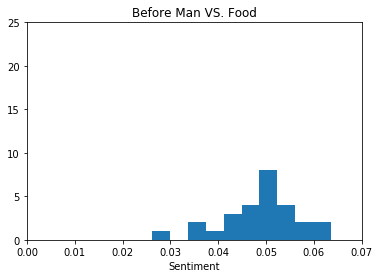

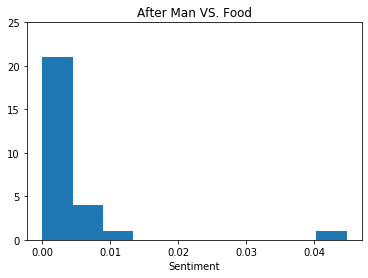

In [41]:
before_and_after('../Desktop/ManVSFood/', snails, MvF_shows, "Man VS. Food")


2.32188955617559
0.8055576935048816
1.5163318626707085


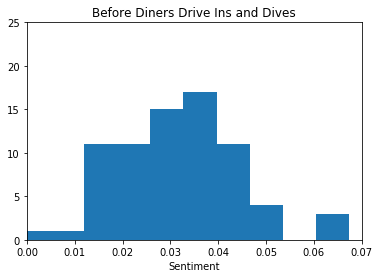

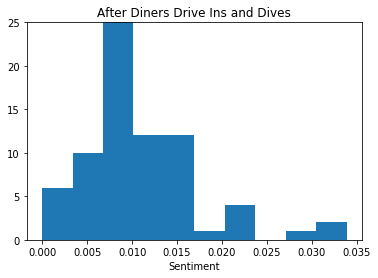

In [42]:
before_and_after('../Desktop/DinersDriveIns/', turtles, DDD_shows, "Diners Drive Ins and Dives")

1.9289996603235895
0.07168960624836798
1.8573100540752214


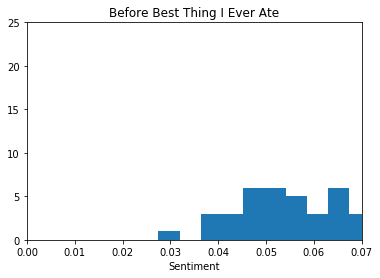

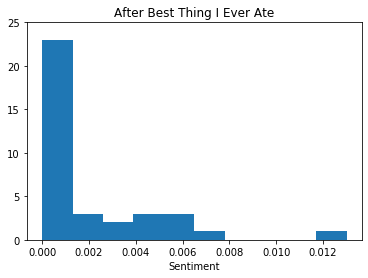

In [43]:
before_and_after('../Desktop/BestThing/', tortoise, Best_shows, "Best Thing I Ever Ate")